# Machine Learning : Projet Real Estate

### Tree and Random Forest

##### Membres : Zakaria Kabara - Valentin Lhote - Omar Mousteau - Marijan Sorić

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
#import tensorflow as tf
import random

In [2]:
X_train_path = "X_train_J01Z4CN.csv"   # Ouverture et conversion en dataframe du X d'entrainement
X_train = pd.read_csv(X_train_path)
print(X_train.dtypes) # Liste des paramètres dans le X ainsi que leur type
X_train.shape # 5 premières lignes de la Dataframe

id_annonce                       int64
property_type                   object
approximate_latitude           float64
approximate_longitude          float64
city                            object
postal_code                      int64
size                           float64
floor                          float64
land_size                      float64
energy_performance_value       float64
energy_performance_category     object
ghg_value                      float64
ghg_category                    object
exposition                      object
nb_rooms                       float64
nb_bedrooms                    float64
nb_bathrooms                   float64
nb_parking_places              float64
nb_boxes                       float64
nb_photos                      float64
has_a_balcony                  float64
nb_terraces                    float64
has_a_cellar                   float64
has_a_garage                   float64
has_air_conditioning           float64
last_floor               

(37368, 27)

In [3]:
y_train_path = "y_train_OXxrJt1.csv"    # Ouverture et conversion en dataframe du y d'entrainement
y_train = pd.read_csv(y_train_path)
#y_train.head(5)

In [4]:
"""Création d'un unique dataframe combinant les prix et les attributs de chaque bien"""
df=X_train.copy()
df.insert(1, 'price', y_train['price'])
#df.head()

In [5]:
df.head()

,id_annonce,price,property_type,approximate_latitude,approximate_longitude,city,postal_code,size,floor,land_size,...,nb_parking_places,nb_boxes,nb_photos,has_a_balcony,nb_terraces,has_a_cellar,has_a_garage,has_air_conditioning,last_floor,upper_floors
0,35996577,355000.0,appartement,43.643880,7.117183,villeneuve-loubet,6270,63.0,NaN,NaN,...,0.0,0.0,4.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,35811033,190000.0,appartement,45.695757,4.895610,venissieux,69200,90.0,3.0,NaN,...,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,35731841,39000.0,maison,47.966791,-1.220451,moutiers,35130,61.0,NaN,370.0,...,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,35886765,299000.0,maison,47.289292,-1.878805,cordemais,44360,142.0,NaN,764.0,...,0.0,1.0,8.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,35781137,478000.0,appartement,45.718992,4.844234,lyon-7eme,69007,88.0,3.0,NaN,...,0.0,1.0,5.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


### Preprocessing

On enlève les paramètres que l'on juge moins utiles (on va utiliser lat et long au lieu de la ville/code postal).

In [6]:
df=df.drop(columns=['city','postal_code','energy_performance_category','ghg_category','exposition','nb_photos'])


In [7]:
df.head()

,id_annonce,price,property_type,approximate_latitude,approximate_longitude,size,floor,land_size,energy_performance_value,ghg_value,...,nb_bathrooms,nb_parking_places,nb_boxes,has_a_balcony,nb_terraces,has_a_cellar,has_a_garage,has_air_conditioning,last_floor,upper_floors
0,35996577,355000.0,appartement,43.643880,7.117183,63.0,NaN,NaN,NaN,NaN,...,NaN,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,35811033,190000.0,appartement,45.695757,4.895610,90.0,3.0,NaN,223.0,52.0,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,35731841,39000.0,maison,47.966791,-1.220451,61.0,NaN,370.0,NaN,NaN,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,35886765,299000.0,maison,47.289292,-1.878805,142.0,NaN,764.0,217.0,44.0,...,NaN,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,35781137,478000.0,appartement,45.718992,4.844234,88.0,3.0,NaN,NaN,NaN,...,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


On fixe l'étage à 0 pour les maisons :

In [8]:
df[df['property_type']=="maison"]=df[df['property_type']=="maison"].assign(floor=0.0)
df[df['property_type']=="maison"].loc[:,'floor']

2        0.0
3        0.0
7        0.0
8        0.0
9        0.0
        ... 
37351    0.0
37355    0.0
37356    0.0
37357    0.0
37367    0.0
Name: floor, Length: 15675, dtype: float64

On fixe le land_size des appartement à la size.

In [9]:
df.loc[df['property_type']=="appartement",'land_size']=df.loc[df['property_type']=="appartement",'land_size'].fillna(0)

In [10]:
""" % de NaN par colonne du dtf avec uniquement les appartements"""
print((df[df['property_type']=="appartement"].isna().sum()*100/df[df['property_type']=="appartement"].shape[0]).sort_values(ascending=True))

id_annonce                   0.000000
has_air_conditioning         0.000000
has_a_garage                 0.000000
has_a_cellar                 0.000000
nb_terraces                  0.000000
has_a_balcony                0.000000
nb_boxes                     0.000000
nb_parking_places            0.000000
last_floor                   0.000000
upper_floors                 0.000000
land_size                    0.000000
approximate_longitude        0.000000
approximate_latitude         0.000000
property_type                0.000000
price                        0.000000
nb_rooms                     0.355940
size                         0.648319
nb_bedrooms                  7.131507
nb_bathrooms                37.310113
floor                       38.994470
energy_performance_value    50.746838
ghg_value                   51.840081
dtype: float64


In [11]:
""" % de NaN par colonne du dtf total"""
print((df.isna().sum()*100/df.shape[0]).sort_values(ascending=True))
#sns.heatmap(df[df['property_type']=="appartement"].isna(),cbar=False)

id_annonce                   0.000000
has_air_conditioning         0.000000
has_a_garage                 0.000000
has_a_cellar                 0.000000
nb_terraces                  0.000000
has_a_balcony                0.000000
nb_boxes                     0.000000
nb_parking_places            0.000000
last_floor                   0.000000
upper_floors                 0.000000
approximate_longitude        0.000000
approximate_latitude         0.000000
property_type                0.000000
price                        0.000000
size                         1.370156
nb_rooms                     4.190751
nb_bedrooms                  7.313744
land_size                   17.929779
floor                       31.979234
nb_bathrooms                35.519696
energy_performance_value    48.972383
ghg_value                   50.412117
dtype: float64


On choisit, pour les appartements où le nombre de salles de bains n'est pas spécifié, de fixer ce nombre à 1.

In [12]:
df.loc[df['property_type']=="maison",'nb_bathrooms']=df.loc[df['property_type']=="maison",'nb_bathrooms'].fillna(1)
df.loc[df['property_type']=="appartement",'nb_bathrooms']=df.loc[df['property_type']=="appartement",'nb_bathrooms'].fillna(1)

<AxesSubplot:>

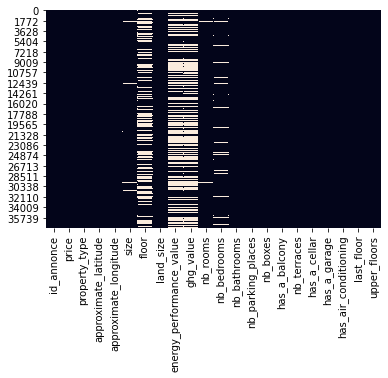

In [13]:
sns.heatmap(df[df['property_type']=="appartement"].isna(),cbar=False)

In [14]:
""" % de NaN par colonne du dtf total"""
print((df.isna().sum()*100/df.shape[0]).sort_values(ascending=True))

id_annonce                   0.000000
has_air_conditioning         0.000000
has_a_garage                 0.000000
has_a_cellar                 0.000000
nb_terraces                  0.000000
has_a_balcony                0.000000
nb_boxes                     0.000000
nb_parking_places            0.000000
last_floor                   0.000000
upper_floors                 0.000000
approximate_longitude        0.000000
approximate_latitude         0.000000
property_type                0.000000
price                        0.000000
size                         1.370156
nb_rooms                     4.190751
nb_bathrooms                 6.674160
nb_bedrooms                  7.313744
land_size                   17.929779
floor                       31.979234
energy_performance_value    48.972383
ghg_value                   50.412117
dtype: float64


<AxesSubplot:ylabel='floor'>

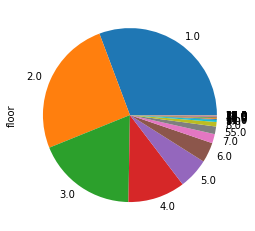

In [15]:
df[df['property_type']=='appartement']['floor'].value_counts().plot.pie()

<AxesSubplot:>

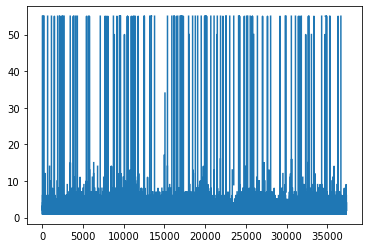

In [16]:
df[df['property_type']=='appartement']['floor'].plot()

(Peut-être ajouter d'autres spécificités sur la moyenne)

In [17]:
type_biens=list(set(list(df['property_type'].values)))
type_biens.remove('appartement')
for bien in type_biens:
#    if df[df['property_type']=="appartement"]['floor'].mean()= np.nan:
    df.loc[df['property_type']==bien,'floor']=df.loc[df['property_type']==bien,'floor'].fillna((df[df['property_type']==bien]['floor']).mean())
    df.loc[df['property_type']==bien,'floor']=df.loc[df['property_type']==bien,'floor'].fillna(0.0)

<AxesSubplot:>

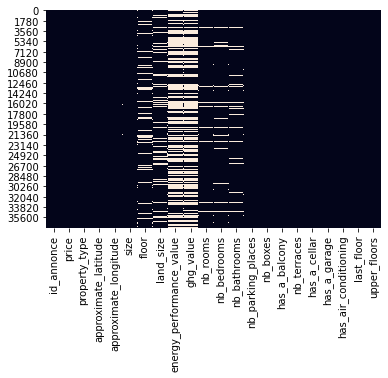

In [18]:
sns.heatmap(df.isna(),cbar=False)

In [19]:
""" % de NaN par colonne"""
print((df.isna().sum()*100/df.shape[0]).sort_values(ascending=True))

id_annonce                   0.000000
has_air_conditioning         0.000000
has_a_garage                 0.000000
has_a_cellar                 0.000000
nb_terraces                  0.000000
has_a_balcony                0.000000
nb_boxes                     0.000000
nb_parking_places            0.000000
last_floor                   0.000000
upper_floors                 0.000000
approximate_longitude        0.000000
approximate_latitude         0.000000
property_type                0.000000
price                        0.000000
size                         1.370156
nb_rooms                     4.190751
nb_bathrooms                 6.674160
nb_bedrooms                  7.313744
floor                       16.417791
land_size                   17.929779
energy_performance_value    48.972383
ghg_value                   50.412117
dtype: float64


On enlève les données énergétique et d'émission :

In [20]:
df.drop(columns=['energy_performance_value','ghg_value'],inplace=True)

In [21]:
for bien in type_biens:

    df.loc[df['property_type']==bien,'land_size']=df.loc[df['property_type']==bien,'land_size'].fillna((df[df['property_type']==bien]['land_size']).mean())
    df.loc[df['property_type']==bien,'land_size']=df.loc[df['property_type']==bien,'land_size'].fillna(0.0)

In [22]:
""" % de NaN par colonne"""
print((df.isna().sum()*100/df.shape[0]).sort_values(ascending=True))

id_annonce                0.000000
has_air_conditioning      0.000000
has_a_garage              0.000000
has_a_cellar              0.000000
nb_terraces               0.000000
has_a_balcony             0.000000
nb_boxes                  0.000000
nb_parking_places         0.000000
last_floor                0.000000
upper_floors              0.000000
land_size                 0.000000
approximate_longitude     0.000000
approximate_latitude      0.000000
property_type             0.000000
price                     0.000000
size                      1.370156
nb_rooms                  4.190751
nb_bathrooms              6.674160
nb_bedrooms               7.313744
floor                    16.417791
dtype: float64


In [23]:
#sns.heatmap(df.isna(),cbar=False)

On enlève toutes les lignes avec des valeurs manquantes, cela nous permet de garder une bonne partie du dataset de départ 

In [24]:
df=df.dropna()
df.shape[0]

27730

In [25]:
""" % de NaN par colonne"""
print((df.isna().sum()*100/df.shape[0]).sort_values(ascending=True))

id_annonce               0.0
has_air_conditioning     0.0
has_a_garage             0.0
has_a_cellar             0.0
nb_terraces              0.0
has_a_balcony            0.0
nb_boxes                 0.0
nb_parking_places        0.0
nb_bathrooms             0.0
nb_bedrooms              0.0
nb_rooms                 0.0
land_size                0.0
floor                    0.0
size                     0.0
approximate_longitude    0.0
approximate_latitude     0.0
property_type            0.0
price                    0.0
last_floor               0.0
upper_floors             0.0
dtype: float64


### Encodage

In [26]:
df.set_index('id_annonce',inplace=True)

In [27]:
df.dtypes

price                    float64
property_type             object
approximate_latitude     float64
approximate_longitude    float64
size                     float64
floor                    float64
land_size                float64
nb_rooms                 float64
nb_bedrooms              float64
nb_bathrooms             float64
nb_parking_places        float64
nb_boxes                 float64
has_a_balcony            float64
nb_terraces              float64
has_a_cellar             float64
has_a_garage             float64
has_air_conditioning     float64
last_floor               float64
upper_floors             float64
dtype: object

In [28]:
# calculer la matrice de corrélation et extraire la colonne "price"
corr_price = df.corr()['price']

# trier les corrélations par ordre croissant
corr_price_sorted = corr_price.sort_values(ascending=False)

# afficher les corrélations triées
print(corr_price_sorted)

price                    1.000000
nb_bedrooms              0.313925
nb_rooms                 0.289252
nb_bathrooms             0.202406
has_a_cellar             0.159152
nb_terraces              0.127947
floor                    0.115925
approximate_longitude    0.114318
has_a_balcony            0.075653
nb_parking_places        0.074233
has_air_conditioning     0.066625
last_floor               0.053412
has_a_garage             0.029625
land_size                0.027683
approximate_latitude     0.026049
nb_boxes                 0.017086
size                     0.015261
upper_floors            -0.005352
Name: price, dtype: float64


<AxesSubplot:>

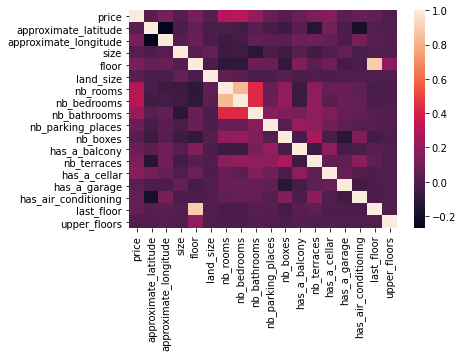

In [29]:
sns.heatmap(df.corr())

On encode les valeurs de type de propriété :

In [30]:
df=pd.get_dummies(df,columns=['property_type'])

In [31]:
df

,price,approximate_latitude,approximate_longitude,size,floor,land_size,nb_rooms,nb_bedrooms,nb_bathrooms,nb_parking_places,...,property_type_maison,property_type_manoir,property_type_moulin,property_type_parking,property_type_propriété,property_type_péniche,property_type_terrain,property_type_terrain à bâtir,property_type_viager,property_type_villa
id_annonce,,,,,,,,,,,,,,,,,,,,,
35811033,190000.0,45.695757,4.895610,90.0,3.0,0.000000,5.0,4.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0
35731841,39000.0,47.966791,-1.220451,61.0,0.0,370.000000,2.0,1.0,1.0,0.0,...,1,0,0,0,0,0,0,0,0,0
35886765,299000.0,47.289292,-1.878805,142.0,0.0,764.000000,4.0,3.0,1.0,0.0,...,1,0,0,0,0,0,0,0,0,0
35781137,478000.0,45.718992,4.844234,88.0,3.0,0.000000,4.0,3.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0
36049101,2050000.0,48.884067,2.270220,1758.0,5.0,0.000000,6.0,3.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35781853,189000.0,44.879393,-0.523138,70.0,2.0,0.000000,4.0,3.0,1.0,1.0,...,0,0,0,0,0,0,0,0,0,0
35840537,55000.0,45.158178,4.613149,2000.0,0.0,6090.368664,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,1,0,0,0
35890109,399000.0,48.861391,2.401158,36.0,4.0,0.000000,2.0,1.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [32]:
df.columns

Index(['price', 'approximate_latitude', 'approximate_longitude', 'size',
       'floor', 'land_size', 'nb_rooms', 'nb_bedrooms', 'nb_bathrooms',
       'nb_parking_places', 'nb_boxes', 'has_a_balcony', 'nb_terraces',
       'has_a_cellar', 'has_a_garage', 'has_air_conditioning', 'last_floor',
       'upper_floors', 'property_type_appartement', 'property_type_atelier',
       'property_type_chalet', 'property_type_château', 'property_type_divers',
       'property_type_duplex', 'property_type_ferme', 'property_type_gîte',
       'property_type_hôtel particulier', 'property_type_loft',
       'property_type_maison', 'property_type_manoir', 'property_type_moulin',
       'property_type_parking', 'property_type_propriété',
       'property_type_péniche', 'property_type_terrain',
       'property_type_terrain à bâtir', 'property_type_viager',
       'property_type_villa'],
      dtype='object')

## Modèles :

In [33]:
X = df.drop(columns=['price'])
y = df['price']

In [34]:
# On split les données
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)

### Regression Linéaire

In [35]:
from sklearn.linear_model import Ridge

In [36]:
linear_regression = Ridge(alpha=1)

linear_regression.fit(X_train,y_train)

Ridge(alpha=1)

In [37]:
linear_regression.intercept_ # Valeur à l'origine

-232721.44156796823

In [38]:
linear_regression.coef_ # Coefficients

array([ 7.74077818e+03,  9.96790745e+03,  1.41158535e+00,  1.76054416e+04,
        1.67241308e-01,  1.83930144e+04,  4.70140955e+04,  3.29800043e+04,
       -1.53280151e+04, -2.36520464e+04, -7.94476636e+03,  4.03811730e+04,
        5.03618506e+04,  2.41019604e+04,  7.85368436e+04, -7.52539134e+05,
       -8.76564659e+05, -2.78707695e+02,  7.03806247e+05, -4.45174242e+03,
        2.31395347e+05, -2.99761655e+05, -1.01366299e+05, -1.85439140e+05,
        2.02337647e+04,  1.85839201e+04,  5.82150490e+04, -1.44181611e+05,
       -1.05102682e+05, -5.77475319e+04, -1.05990333e+05,  5.79927944e+04,
        2.67830183e+05, -3.53291314e+04, -4.22855300e+04, -2.96918967e+05,
        2.07960257e+04])

In [39]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mse 
from sklearn.metrics import mean_absolute_error as mae

y_pred = linear_regression.predict(X_test)

#print('mean squared error =',mse(y_test, y_pred))
print('mean absolute error =',mae(y_test, y_pred))
print('r2 score =', r2_score(y_test, y_pred))

mean absolute error = 177882.4523123836
r2 score = 0.21619199049616


In [40]:
moy_prix=y_test.mean()
y_naif = pd.DataFrame(moy_prix*np.ones(y_test.shape[0]))

#print('mean squared error =',mse(y_test, y_pred))
print('mean absolute error =',mae(y_test, y_naif))
print('r2 score =', r2_score(y_test, y_naif))

mean absolute error = 208794.0227543846
r2 score = 0.0


### Trees


#### Simple tree

In [41]:
from sklearn.tree import DecisionTreeRegressor

tree = DecisionTreeRegressor()

tree.fit(X_train,y_train)

DecisionTreeRegressor()

In [42]:
y_pred = tree.predict(X_test)

#print('mean squared error =',mse(y_test, y_pred))
print('mean absolute error =',mae(y_test, y_pred))
print('r2 score =', r2_score(y_test, y_pred))

mean absolute error = 117364.32293544897
r2 score = 0.55821264400939


#### Optimized tree

L'idée est d'utiliser le GridSearchCV pour trouver les meilleurs paramètres

In [43]:
# Paramètres à tester

parameters = {'criterion':["squared_error", "friedman_mse", "absolute_error", "poisson"],
              'splitter' : ['best', 'random'],
              'max_depth': np.arange(1, 50, 1),
             'cv' : np.arange(1,20)}

In [44]:
from sklearn.model_selection import GridSearchCV

tree_1 = DecisionTreeRegressor()
grid = GridSearchCV(tree_1, parameters)

grid.fit(X_train, y_train)

C:\Users\33781\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\33781\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\33781\anaconda3\lib\site-packages\sklearn\tree\_classes.py", line 1247, in fit
    super().fit(
  File "C:\Users\33781\anaconda3\lib\site-packages\sklearn\tree\_classes.py", line 350, in fit
    criterion = CRITERIA_REG[self.criterion](self.n_outputs_,
KeyError: 'squared_error'

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\33781\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Detai

GridSearchCV(estimator=DecisionTreeRegressor(),
             param_grid={'criterion': ['squared_error', 'friedman_mse',
                                       'absolute_error', 'poisson'],
                         'max_depth': [None, 2, 25, 50, 100, 500, 1000]})

In [45]:
pd.DataFrame(grid.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.009386,0.001811,0.000000,0.000000,squared_error,None,"{'criterion': 'squared_error', 'max_depth': None}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,28
1,0.007894,0.006988,0.000000,0.000000,squared_error,2,"{'criterion': 'squared_error', 'max_depth': 2}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,16
2,0.012497,0.006249,0.000000,0.000000,squared_error,25,"{'criterion': 'squared_error', 'max_depth': 25}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,17
3,0.006602,0.006319,0.000000,0.000000,squared_error,50,"{'criterion': 'squared_error', 'max_depth': 50}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,25
4,0.008624,0.006068,0.000000,0.000000,squared_error,100,"{'criterion': 'squared_error', 'max_depth': 100}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,26
5,0.009682,0.003301,0.000000,0.000000,squared_error,500,"{'criterion': 'squared_error', 'max_depth': 500}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,15
6,0.009372,0.007652,0.000000,0.000000,squared_error,1000,"{'criterion': 'squared_error', 'max_depth': 1000}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,27
7,0.153990,0.007949,0.000000,0.000000,friedman_mse,None,"{'criterion': 'friedman_mse', 'max_depth': None}",0.467003,0.532879,0.506368,0.549583,0.486328,0.508432,0.030001,6
8,0.028118,0.006249,0.000000,0.000000,friedman_mse,2,"{'criterion': 'friedman_mse', 'max_depth': 2}",0.130623,0.134655,0.128431,0.144871,0.138449,0.135406,0.005847,7
9,0.149987,0.009535,0.004732,0.006282,friedman_mse,25,"{'criterion': 'friedman_mse', 'max_depth': 25}",0.484251,0.536821,0.516734,0.536369,0.501359,0.515107,0.020334,3


In [46]:
grid.best_params_

{'criterion': 'friedman_mse', 'max_depth': 500}

In [47]:
y_pred = grid.best_estimator_.predict(X_test)

#print('mean squared error =',mse(y_test, y_pred))
print('mean absolute error =',mae(y_test, y_pred))
print('r2 score =', r2_score(y_test, y_pred))

mean absolute error = 117603.48791922106
r2 score = 0.5512148924121947


### Random Forests

In [48]:
from sklearn.ensemble import RandomForestRegressor

random_forest = RandomForestRegressor()
random_forest.fit(X_train, y_train)

RandomForestRegressor()

In [49]:
y_pred = random_forest.predict(X_test)

#print('mean squared error =',mse(y_test, y_pred))
print('mean absolute error =',mae(y_test, y_pred))
print('r2 score =', r2_score(y_test, y_pred))

mean absolute error = 86829.73475297511
r2 score = 0.7740038472673632


#### Random Forest with Best Params

In [50]:
parameters = {'n_estimators' : [25,50,100,200]} # Devient très long pour plus de 200

In [51]:
random_forest_1 = RandomForestRegressor()
grid = GridSearchCV(random_forest_1, parameters)

grid.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestRegressor(),
             param_grid={'n_estimators': [25, 50, 100, 200]})

In [52]:
grid.best_params_

{'n_estimators': 200}

In [53]:
y_pred = grid.best_estimator_.predict(X_test)

#print('mean squared error =',mse(y_test, y_pred))
print('mean absolute error =',mae(y_test, y_pred))
print('r2 score =', r2_score(y_test, y_pred))

mean absolute error = 86436.96635953839
r2 score = 0.7756576839871078


### XGBoost